# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

### Cargando datos y librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from numpy.random import RandomState

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=0)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Comenzamos el preprocesamiento de datos con la columna que contiene las fechas la cualno tenia el formato adeuado por lo que lo cambiamos desde la creacion del dataframe, ahora si tenemos el formado de fecha en la columna correspondiente y la colocamos en el indice, ahora seguiremos con el proceso buscando valores nulos, duplicados y outliers.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.duplicated().sum()

26415

In [6]:
df_duplicated = df[df.duplicated(keep = False)]
df_duplicated

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Los valores duplicados corresponden a las fechas ya que estas se repiten en el registro del mes, ahora ordenaremos el dataframe por fecha y nos aseguraremos de que al final lo este.

In [7]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


En la tbla de arriba nos damos cuenta que primero el dataframe esta bastante balanceado ya que la media y la mediana son muy cercanas y tambien vemos que tenemos outliers ya que de 19 que corresponde al 75% pasa a un maximo de 119 graficaremos para ver esto con mayor detalle.

Text(0.5, 1.0, 'Outliners')

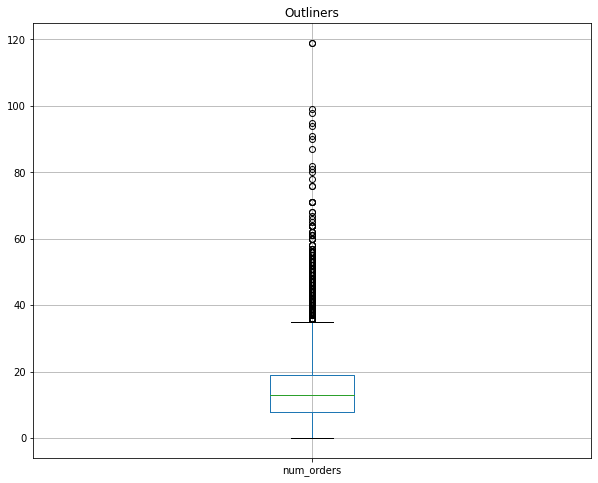

In [9]:
df.boxplot(figsize=(10,8))
plt.title('Outliners')

Se puede ver claramente que si tenemos outliers pero no corresponden a llenado erroneo de datos como se puede suponer en otros dataframes que hemos analizado al contrario estos corresponden a valores documentados que podrian ayudar al modelo ya que podrian pertenecer a fechas especificas que necesiten mas viajes por lo que los dejaremos, a continuacion realizaremos graficas para poder determinar la tendencia y estacionalidad.

### Tendencia y Estacionalidad

Text(0.5, 1.0, 'Total orders')

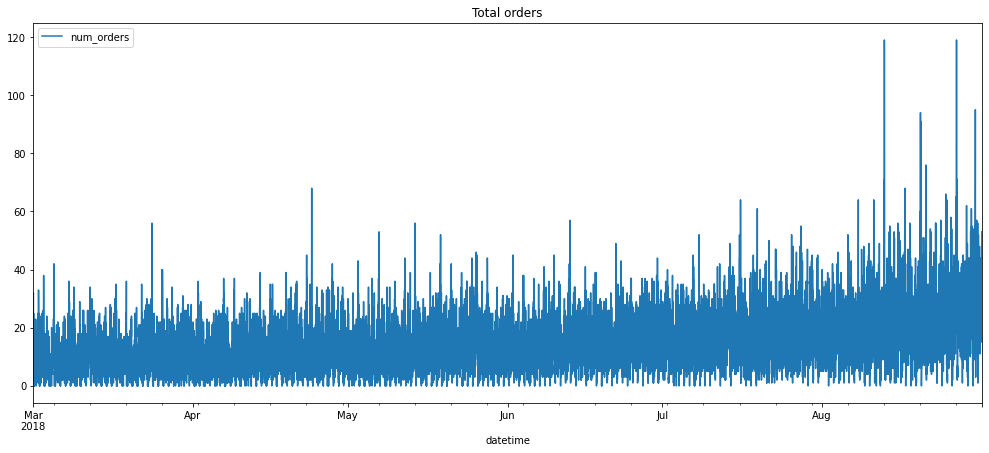

In [10]:
# Graficamos el dataframe sin ajustes.
df.plot(figsize=(17,7))
plt.title('Total orders')

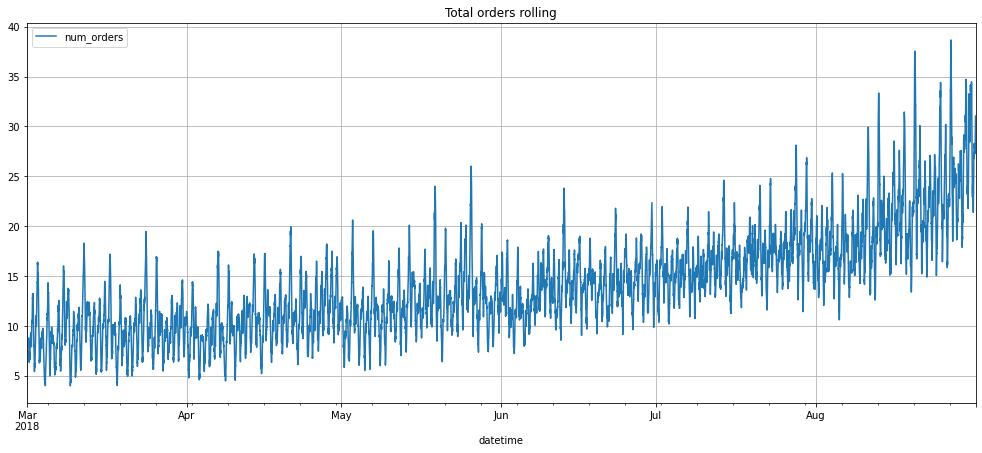

In [11]:
# Graficamos el dataframe usando rolling = 50
df.rolling(50).mean().plot(figsize=(17,7), grid=True)
plt.title('Total orders rolling')
plt.show()

Para las siguientes graficas analizaremos varias graficas con remuestreo de un dia, una semana, un mes y despues pasaremos a realizar las graficas de tendencia y estacionalidad.

Text(0.5, 1.0, 'Total orders in one week')

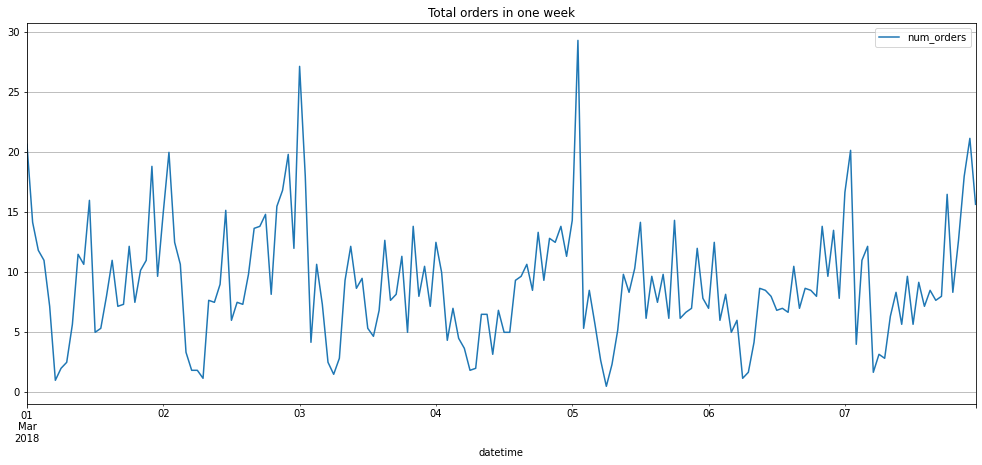

In [12]:
# Grafica de una semana remuestreo de horas.
df_week=df['2018-03-01':'2018-03-07'].resample('1H').mean()
df_week.plot(figsize=(17,7), grid=True)
plt.title('Total orders in one week')

Text(0.5, 1.0, 'Total orders by day')

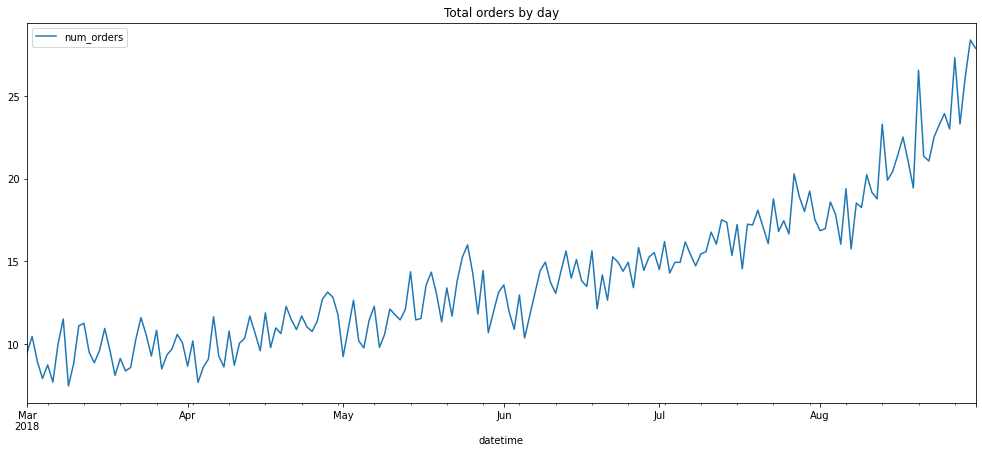

In [13]:
# Grafica remuestreo dias.
df_day=df.resample('1D').mean()
df_day.plot(figsize=(17,7))
plt.title('Total orders by day')

Text(0.5, 1.0, 'Total orders by hour')

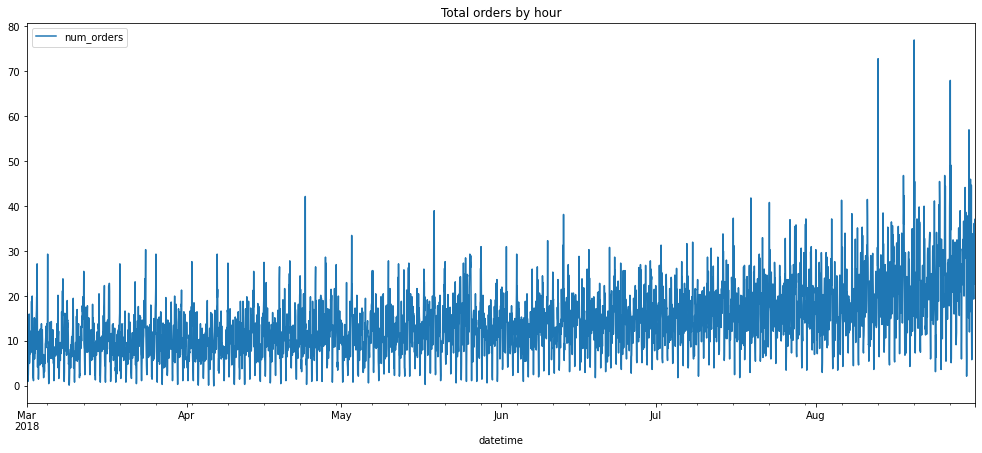

In [14]:
# Grafica remuestreo horas
df_hour=df.resample('1H').mean()
df_hour.plot(figsize=(17,7))
plt.title('Total orders by hour')

Text(0.5, 1.0, 'Total orders by hour rolling')

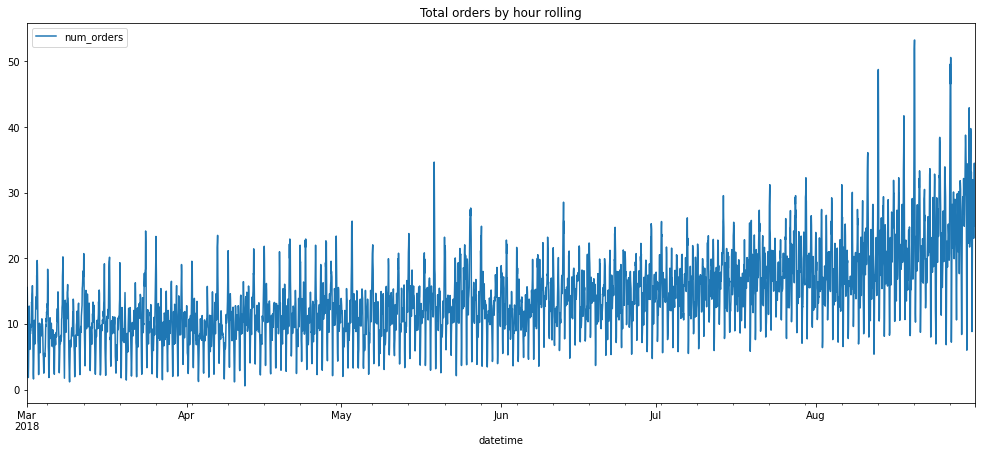

In [15]:
df_hour.rolling(3).mean().plot(figsize=(17,7))
plt.title('Total orders by hour rolling')

En la primer grafica podemos ver que durante la primer semna de registros se mantienen variantes especificas dependiendo de una determinada hora practicamente en todos los dias con pequeñas variaciones.

En la segunda y tercer grafica vemos como al pasar del año los viajes aumentan eso es mas notorio en la segunda grafica de los dias, ahora realizaremos la grafica de tendencia y estacionalidad como lo pide el ejercicio esto se realizara por horas.

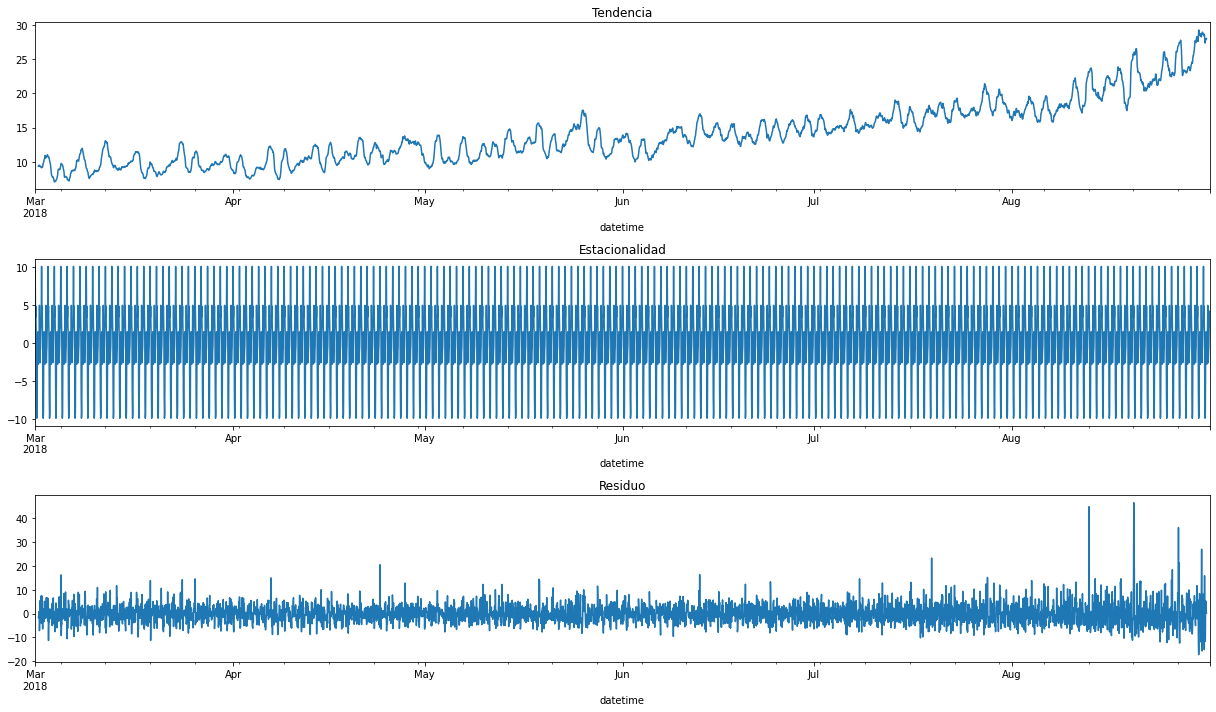

In [16]:
decomposed = seasonal_decompose(df_hour)

plt.figure(figsize=(17,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuo')
plt.tight_layout()

Podemos ver que tenemos un estacionalidad que no es muy clara por lo que lo haremos nuevamente con remuestreo de dias.

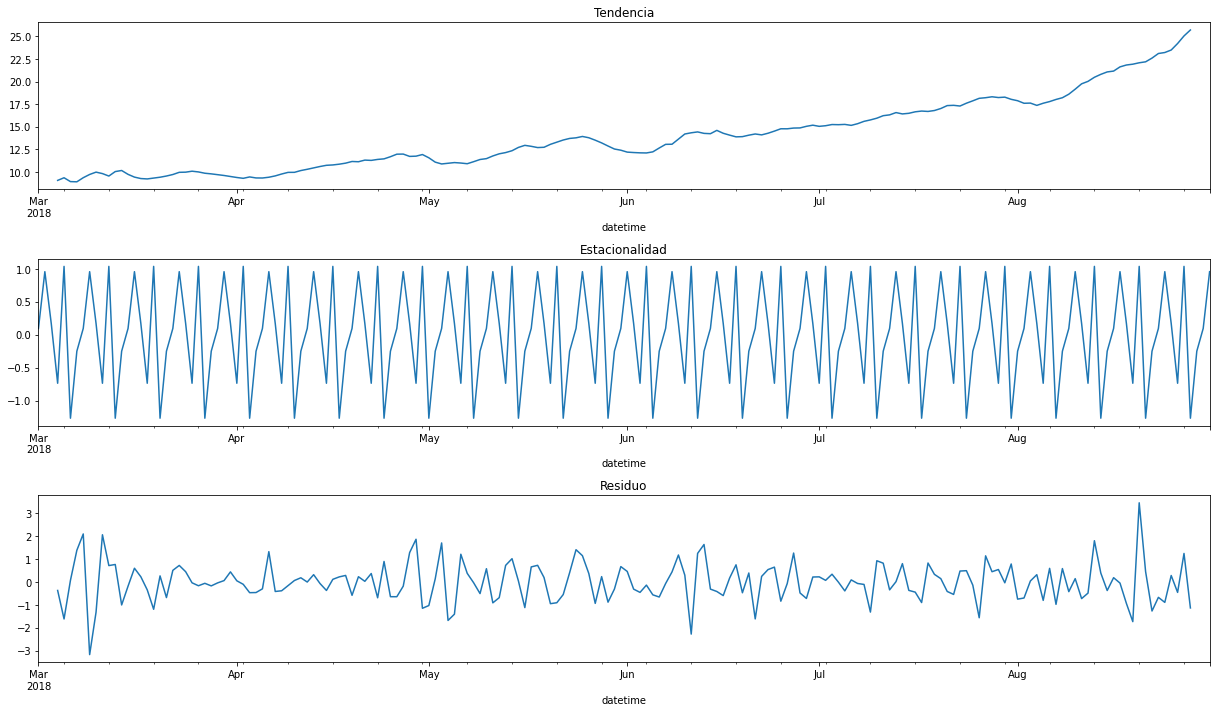

In [17]:
decomposed = seasonal_decompose(df_day)

plt.figure(figsize=(17,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuo')
plt.tight_layout()

Ahora si queda mas clara la estacionalidad que es muy parecida a la primer grafica que teniamos donde mostrabamos el remuestreo de una semana por horas, tenemos claro que la cantidad de viajes varia dependiendo de las horas aunque tambien pudimos ver esa variacion en los dias.

Lo siguiente sera modificar el dataframe con remuestreo de horas como se nos solicito.

## Preparación

In [18]:
# Remuestreo por horas.
df_train = df.resample('1H').sum()
df_train

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [19]:
# Creamos las columnas de hora, dia, dia de la semana y mes ademas de las columnas para tener una serie etacionaria.
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data        

make_features(df_train, 4, 6)
df_train

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,3,66.0,71.0,85.0,124.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,8,207.0,217.0,197.0,116.0,172.666667
2018-08-31 20:00:00,154,20,31,4,8,136.0,207.0,217.0,197.0,167.666667
2018-08-31 21:00:00,159,21,31,4,8,154.0,136.0,207.0,217.0,171.166667


In [20]:
#Eliminamos valores nulos.
df_train.dropna(inplace=True)
df_train

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,6,1,3,3,6.0,43.0,66.0,71.0,65.833333
2018-03-01 07:00:00,15,7,1,3,3,12.0,6.0,43.0,66.0,47.166667
2018-03-01 08:00:00,34,8,1,3,3,15.0,12.0,6.0,43.0,35.500000
2018-03-01 09:00:00,69,9,1,3,3,34.0,15.0,12.0,6.0,29.333333
2018-03-01 10:00:00,64,10,1,3,3,69.0,34.0,15.0,12.0,29.833333
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,8,207.0,217.0,197.0,116.0,172.666667
2018-08-31 20:00:00,154,20,31,4,8,136.0,207.0,217.0,197.0,167.666667
2018-08-31 21:00:00,159,21,31,4,8,154.0,136.0,207.0,217.0,171.166667


### Features y targets

Crearemos nuestros features y targets dividienso en muestras de entrenamiento validacion y testeo.

In [21]:
rs=12345

In [22]:
features = df_train.drop(['num_orders'], axis=1)
target = df_train['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.10, random_state=rs, shuffle=False)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=rs)

print('Entrenamiento')
print(features_train.shape)
print(target_train.shape)
print()
print('Validacion')
print(features_valid.shape)
print(target_valid.shape)
print()
print('Testeo')
print(features_test.shape)
print(target_test.shape)

Entrenamiento
(2976, 9)
(2976,)

Validacion
(993, 9)
(993,)

Testeo
(441, 9)
(441,)


## Análisis

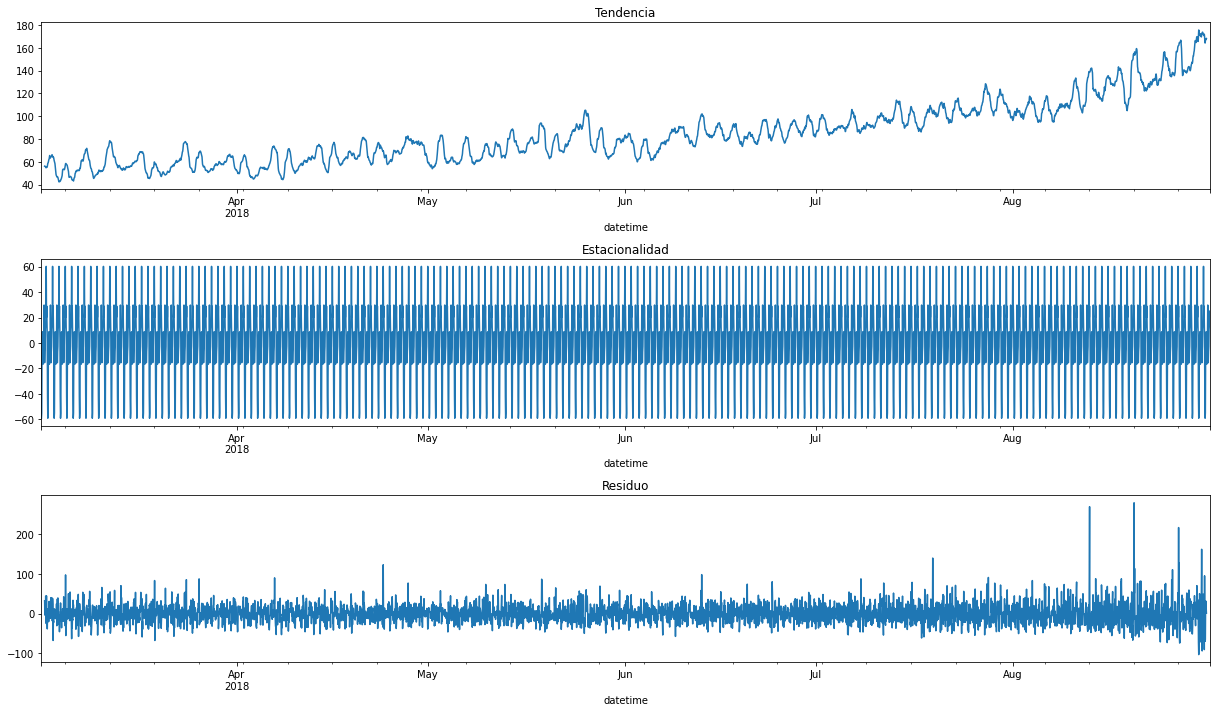

In [23]:
decomposed = seasonal_decompose(df_train['num_orders'])

plt.figure(figsize=(17,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuo')
plt.tight_layout()

Si graficamos el dataframe con los ajustes de remuestreo por horas tenemos nuevamente la grafica que habiamos obtenido antes la cual nos muestra aunque de manera poco clara la estacionalidad, sin embargo ya vimos con el analisis que hicimos anteriormente que vamos por buen camino y el dataframe que tenemos ya esta listo para realizar las pruebas con los modelos.

## Formación

Realizaremos el entrenamiento con modelos de Random Forest, CatBoost y Ligth GBM que son los que daban los mejores resultados, pero primero realizaremos una prueba de cordura nuevamente con Regression Lineal y tomaremos como referencia para el resultado la metrica RECM como se nos solicito.

### Logistic regression (prueba de cordura)

In [24]:
reg = LinearRegression()
reg.fit(features_train, target_train)
reg_pred = reg.predict(features_valid)
print('RECM: ')
print(mean_squared_error(target_valid, reg_pred)**0.5)

RECM: 
29.54519782196422


### Random Forest

In [25]:
score = max(df_train['num_orders'])
n=1
for roots in range(3,8):
    for leafs in range(3,8):
        forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs)
        forest.fit(features_train, target_train)
        forest_pred = forest.predict(features_valid)
        sco = mean_squared_error(target_valid, forest_pred)**0.5
        if sco<score:
            score = sco
            best_root = roots
            best_leaf = leafs
            best_pred = forest_pred
            best_n = n
        n+=1

best_forest = RandomForestRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
print('Mejor ronda:', best_n)
print('Mejor RECM:', score)
print('Raices:', best_root)
print('Hojas:', best_leaf)

Mejor ronda: 25
Mejor RECM: 22.705124359212466
Raices: 7
Hojas: 7


### CatBoost

In [26]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))
cat_pred = cat.predict(features_valid)
print('RECM:')
print(mean_squared_error(target_valid, cat_pred)**0.5)

RECM:
21.07815471505319


### Ligth GBM

In [27]:
lgbm = lgb.LGBMRegressor(random_state=rs)
lgbm.fit(features_train, target_train,eval_metric = 'RMSE', eval_set=(features_valid, target_valid))
lgbm_pred = lgbm.predict(features_valid)
print('RECM:')
print(mean_squared_error(target_valid, lgbm_pred)**0.5)

[1]	valid_0's rmse: 35.1257	valid_0's l2: 1233.81
[2]	valid_0's rmse: 33.1667	valid_0's l2: 1100.03
[3]	valid_0's rmse: 31.5283	valid_0's l2: 994.033
[4]	valid_0's rmse: 30.1235	valid_0's l2: 907.423
[5]	valid_0's rmse: 28.9064	valid_0's l2: 835.578
[6]	valid_0's rmse: 27.8619	valid_0's l2: 776.284
[7]	valid_0's rmse: 26.919	valid_0's l2: 724.632
[8]	valid_0's rmse: 26.1513	valid_0's l2: 683.893
[9]	valid_0's rmse: 25.5484	valid_0's l2: 652.722
[10]	valid_0's rmse: 25.0029	valid_0's l2: 625.143
[11]	valid_0's rmse: 24.5437	valid_0's l2: 602.393
[12]	valid_0's rmse: 24.1026	valid_0's l2: 580.938
[13]	valid_0's rmse: 23.7728	valid_0's l2: 565.148
[14]	valid_0's rmse: 23.4541	valid_0's l2: 550.095
[15]	valid_0's rmse: 23.0816	valid_0's l2: 532.762
[16]	valid_0's rmse: 22.8481	valid_0's l2: 522.034
[17]	valid_0's rmse: 22.5814	valid_0's l2: 509.92
[18]	valid_0's rmse: 22.3785	valid_0's l2: 500.796
[19]	valid_0's rmse: 22.2402	valid_0's l2: 494.625
[20]	valid_0's rmse: 21.9924	valid_0's l2:

El modelo con el mejor resultado fue CatBoost Seguido muy de cerca por Ligth GBM apenas por unas decimas, dado que los resultados fueron tan parejos haremos la prueba con ambos modelos añadiendo algunos hiperparametros para tratar de mejorar los resultados, esto no se hara con el Random Forest por que el modelo ya se entreno con hiperparametros.

## Prueba

In [28]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_train, target_train, eval_set=(features_test, target_test))
cat_pred = cat.predict(features_test)
print('RECM:')
print(mean_squared_error(target_test, cat_pred)**0.5)

RECM:
42.3397477643129


In [29]:
lgbm = lgb.LGBMRegressor(random_state=rs)
lgbm.fit(features_train, target_train, eval_metric ='RMSE', eval_set=(features_test, target_test))
lgbm_pred = lgbm.predict(features_test)
print('RECM:')
print(mean_squared_error(target_test, lgbm_pred)**0.5)

[1]	valid_0's rmse: 80.9808	valid_0's l2: 6557.89
[2]	valid_0's rmse: 77.8912	valid_0's l2: 6067.04
[3]	valid_0's rmse: 75.1118	valid_0's l2: 5641.79
[4]	valid_0's rmse: 72.6572	valid_0's l2: 5279.07
[5]	valid_0's rmse: 69.9425	valid_0's l2: 4891.95
[6]	valid_0's rmse: 67.5122	valid_0's l2: 4557.89
[7]	valid_0's rmse: 65.3445	valid_0's l2: 4269.9
[8]	valid_0's rmse: 63.6749	valid_0's l2: 4054.49
[9]	valid_0's rmse: 61.8631	valid_0's l2: 3827.04
[10]	valid_0's rmse: 60.6023	valid_0's l2: 3672.63
[11]	valid_0's rmse: 58.924	valid_0's l2: 3472.03
[12]	valid_0's rmse: 57.7334	valid_0's l2: 3333.14
[13]	valid_0's rmse: 56.3305	valid_0's l2: 3173.13
[14]	valid_0's rmse: 55.3021	valid_0's l2: 3058.32
[15]	valid_0's rmse: 54.4133	valid_0's l2: 2960.8
[16]	valid_0's rmse: 53.6444	valid_0's l2: 2877.72
[17]	valid_0's rmse: 52.8487	valid_0's l2: 2792.99
[18]	valid_0's rmse: 52.3147	valid_0's l2: 2736.82
[19]	valid_0's rmse: 51.3964	valid_0's l2: 2641.59
[20]	valid_0's rmse: 50.6609	valid_0's l2: 

Los resultados con el el set de prueba no mejoraron los resultados al contrario perdimos mas de 20 puntos, sin embargo aun nos mantenemos por debajo de los 48 puntos que nos solicitaban, ahora realizaremos nuevamente la prueba añadiendo algunos hiperparametros. 

### Prueba con hiperparametros

In [30]:
score = max(df_train['num_orders'])
for metric in ['MAE', 'MAPE', 'Poisson', 'RMSE']:
    for roots in range(3,10):
        for leafs in range(3,10):
            cat2 = CatBoostRegressor(iterations=200, silent=True, l2_leaf_reg=leafs, depth=roots, loss_function=metric)
            cat2.fit(features_train, target_train, eval_set=(features_test, target_test))
            cat_pred = cat2.predict(features_test)
            sco = mean_squared_error(target_test, cat_pred)**0.5
            if sco<score:
                score = sco
                best_root = roots
                best_leaf = leafs
                best_metric = metric
                best_pred = sco

print('RECM:', best_pred)
print('Depth:', best_root)
print('Leafs:', best_leaf)
print('Metric:', best_metric)

RECM: 48.08235213141329
Depth: 6
Leafs: 3
Metric: RMSE


In [31]:
score = max(df_train['num_orders'])
for roots in range(3,10):
    for leaves in range(3,10):
        lgbm2 = lgb.LGBMRegressor(num_leaves=leaves, max_depth=roots)
        lgbm2.fit(features_train, target_train, eval_metric = metric, eval_set=(features_test, target_test))
        lgbm2_pred = lgbm2.predict(features_test)
        sco = mean_squared_error(target_test, lgbm2_pred)**0.5
        if sco<score:
            score = sco
            best_root = roots
            best_leave = leaves
            best_metric = metric
            best_pred = sco

print('RECM:', best_pred)
print('Depth:', best_root)
print('Leafs:', best_leaf)
print('Metric:', best_metric)

[1]	valid_0's rmse: 83.4533	valid_0's l2: 6964.46
[2]	valid_0's rmse: 81.316	valid_0's l2: 6612.3
[3]	valid_0's rmse: 80.0186	valid_0's l2: 6402.97
[4]	valid_0's rmse: 79.2297	valid_0's l2: 6277.35
[5]	valid_0's rmse: 77.9021	valid_0's l2: 6068.73
[6]	valid_0's rmse: 76.0361	valid_0's l2: 5781.49
[7]	valid_0's rmse: 74.8042	valid_0's l2: 5595.67
[8]	valid_0's rmse: 74.2916	valid_0's l2: 5519.24
[9]	valid_0's rmse: 73.197	valid_0's l2: 5357.81
[10]	valid_0's rmse: 72.6581	valid_0's l2: 5279.2
[11]	valid_0's rmse: 71.689	valid_0's l2: 5139.31
[12]	valid_0's rmse: 70.7122	valid_0's l2: 5000.21
[13]	valid_0's rmse: 69.8099	valid_0's l2: 4873.42
[14]	valid_0's rmse: 69.3783	valid_0's l2: 4813.35
[15]	valid_0's rmse: 68.7462	valid_0's l2: 4726.04
[16]	valid_0's rmse: 68.0258	valid_0's l2: 4627.51
[17]	valid_0's rmse: 67.8581	valid_0's l2: 4604.72
[18]	valid_0's rmse: 67.1834	valid_0's l2: 4513.61
[19]	valid_0's rmse: 66.2622	valid_0's l2: 4390.68
[20]	valid_0's rmse: 65.9837	valid_0's l2: 43

Vemos como afinando algunos hiperparametros el modelo Ligth GBM nos da mejores resultados, posiblemente aumentando los hiperparametros de CatBoost tambien nos de mejoras sin embargo el tiempo de iteracion tambien aumentaria, a pesar de que el ultimo resultado mejoro no lo hizo mas que el primer resultado que fue el CatBoost sin ajuste de hiperparametros, por lo que nos quedaremos con ese como nuestro mejor modelo.

## Conclusion

En esta ocacion los resultados con nuestros sets de prueba no mejoraron los resultados que tenemos con el entrenamiento de los modelos creo que esto se debe a que siendo una serie temporar vimos que tenis cambios a lo largo del tiempo por lo que si nuestro modelo entreno con datos de Marzo y las pruebas se hicieron con datos de Agosto esa fluctuacion de los datos en el tiempo hace que el modelo no de buenos resultados, por lo que necesitariamos mas datos por lo menos de un año completo para que el modelo encuentre las diferencias de los datos en el tiempo, sin embargo nos mantuvimos dentro del parametro que nos solicitaban obteniento un resultado RECM de 41.40.